# LAB 4: Topic modeling

Use topic models to explore hotel reviews

Objectives:
* tokenize with MWEs using spacy
* estimate LDA topic models with tomotopy
* visualize and evaluate topic models
* apply topic models to interpretation of hotel reviews

## Build topic model

In [17]:
import pandas as pd
import numpy as np
from cytoolz import *
from tqdm.auto import tqdm
tqdm.pandas()

### Read in hotel review data and tokenize it

In [18]:
df = pd.read_parquet('hotels.parquet')

In [19]:
from tokenizer import MWETokenizer

tokenizer = MWETokenizer(open('hotel-terms.txt'))

Select a sample of reviews to work with (replace x's below with the sample size; you should use at least 50,000 reviews)

In [20]:
subdf = df.sample(100000)

In [21]:
subdf['tokens'] = pd.Series(subdf['text'].progress_apply(tokenizer.tokenize))

  0%|          | 0/100000 [00:00<?, ?it/s]

### Estimate model

In [22]:
import tomotopy as tp
import time

These are the model **hyperparameters**: aspects of the model that aren't estimated from the data but have to be set in advance by the analyst. There's no "right" values for these. You'll just have to try out different values to find settings that give you a model that you can interpret:

* *k* = number of topics
* *min_df* = minimum number of reviews that a term has to occur in to be included in the model
* *rm_top* = number of most frequent terms to remove from the model
* *tw* = term weighting strategy (described [here](https://bab2min.github.io/tomotopy/v0.10.1/en/#tomotopy.TermWeight)]
* *alpha*, *eta* = priors for document-topic and topic-word distributions
* *tol* = convergence tolerance


In [23]:
k = 100
min_df = 100
rm_top = 75
tw = tp.TermWeight.ONE
alpha = 0.1
eta = 0.01
tol = 1e-3

Here's where we do the inference. The documentation for `LDAModel` is [here](https://bab2min.github.io/tomotopy/v0.10.1/en/#tomotopy.LDAModel). You might also consider trying out one of the other model types (e.g., `HDPModel`).

In [24]:
%%time

mdl = tp.LDAModel(k=k, min_df=min_df, rm_top=rm_top, tw=tw, alpha=alpha, eta=eta)

for doc in subdf['tokens']:
    if doc:
        mdl.add_doc(doc)

last = np.NINF
for i in range(0, 5000, 50):
    mdl.train(50)
    ll = mdl.ll_per_word
    print(f'{i:5d} LL = {ll:7.4f}', flush=True)
    if ll - last < tol:
        break
    else:
        last = ll

print(f'Done!')

    0 LL = -9.0633
   50 LL = -8.8264
  100 LL = -8.7420
  150 LL = -8.6986
  200 LL = -8.6727
  250 LL = -8.6553
  300 LL = -8.6435
  350 LL = -8.6349
  400 LL = -8.6297
  450 LL = -8.6232
  500 LL = -8.6213
  550 LL = -8.6185
  600 LL = -8.6174
  650 LL = -8.6138
  700 LL = -8.6138
Done!
CPU times: user 45min 51s, sys: 26 s, total: 46min 17s
Wall time: 24min 21s


### Evaluate the model

What terms are associated with each topic?

In [25]:
for k in range(mdl.k):
    print(f'{k:3d} ', ', '.join(s for s,_ in mdl.get_topic_words(k)))

  0  parking, car, valet, park, day, street, garage, your, valet_parking, parked
  1  he, him, his, asked, said, told, who, went, guy, husband
  2  evening, wine, free, breakfast, drinks, snacks, reception, cheese, happy_hour, morning
  3  other, some, however, guests, their, while, two, been, than, during
  4  per, day, parking, charge, pay, price, internet, cost, extra, paid
  5  luggage, bags, check, arrived, before, ready, early, checked, after, even
  6  chicago, river, lake, right, shopping, blocks, michigan_ave, park, michigan_avenue, navy_pier
  7  shower, water, bathroom, toilet, hot_water, sink, tub, hot, problem, off
  8  view, floor, views, city, tower, over, river, windows, large, corner_room
  9  towels, day, housekeeping, shampoo, soap, them, cleaned, left, extra, two
 10  tv, channels, bed, watch, ipod, cable, work, television, channel, hd
 11  place, even, ever, worst, never, old, dirty, money, rude, bad
 12  pool, resort, grounds, beautiful, spa, property, kids, pools

Which terms got remove due to `rm_top`?

In [26]:
', '.join(mdl.removed_top_words)

"the, and, a, to, was, i, in, we, of, is, for, it, not, hotel, at, room, were, that, but, this, on, with, very, you, had, have, there, my, are, our, they, from, as, so, would, stay, be, all, do, 's, rooms, if, one, staff, stayed, out, great, when, clean, no, us, an, which, nice, just, or, up, here, about, get, location, good, night, could, can, also, will, me, only, $, by, again, like, well, did"

Visualize topic model with LDAvis

In [27]:
# Does not work in JupyterLab, must be run in Jupyter Notebook
import pyLDAvis

topic_term_dists = np.stack([mdl.get_topic_word_dist(k)
                             for k in range(mdl.k)])
doc_topic_dists = np.stack([doc.get_topic_dist() for doc in mdl.docs])
doc_lengths = np.array([len(doc.words) for doc in mdl.docs])
vocab = list(mdl.used_vocabs)
term_frequency = mdl.used_vocab_freq
prepared_data = pyLDAvis.prepare(topic_term_dists,
                                 doc_topic_dists,
                                 doc_lengths,
                                 vocab,
                                 term_frequency, 
                                 mds='tsne', 
                                 sort_topics=False
                                 )

/opt/conda/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


In [28]:
pyLDAvis.display(prepared_data)

Find documents that best represent each topic

In [29]:
for i,d in enumerate(np.argmax(doc_topic_dists, axis=0)):
    print(i, ', '.join(map(first, mdl.get_topic_words(i))))
    print(subdf['text'].iloc[d])
    print()

0 parking, car, valet, park, day, street, garage, your, valet_parking, parked
Convienent location and very clean! They offer valet parking for $23, but if you don't mind walking a little, I suggest parking at the Walnut Street Garage. It cost $12 and is connected via Skywalk to the hotel.

1 he, him, his, asked, said, told, who, went, guy, husband
I advised the front desk I had two packages,they called the lower level of the hotel I would be stopping by for the packages, when I arrived the man at the security desk had an attitude and utilized a hand gesture to tell me to calm down-I was perfectly calm until I was confronted by his body language, when he brought me the package he asked for a tip. How rude. I immediately went to talk to the front desk manager and he did not give a dam..
I am a Sales Manager for a very well know property in Philadelphia and I am appauled by both employees behavior.Simply awful.

2 evening, wine, free, breakfast, drinks, snacks, reception, cheese, happy_ho

Generate word clouds for topics

In [30]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

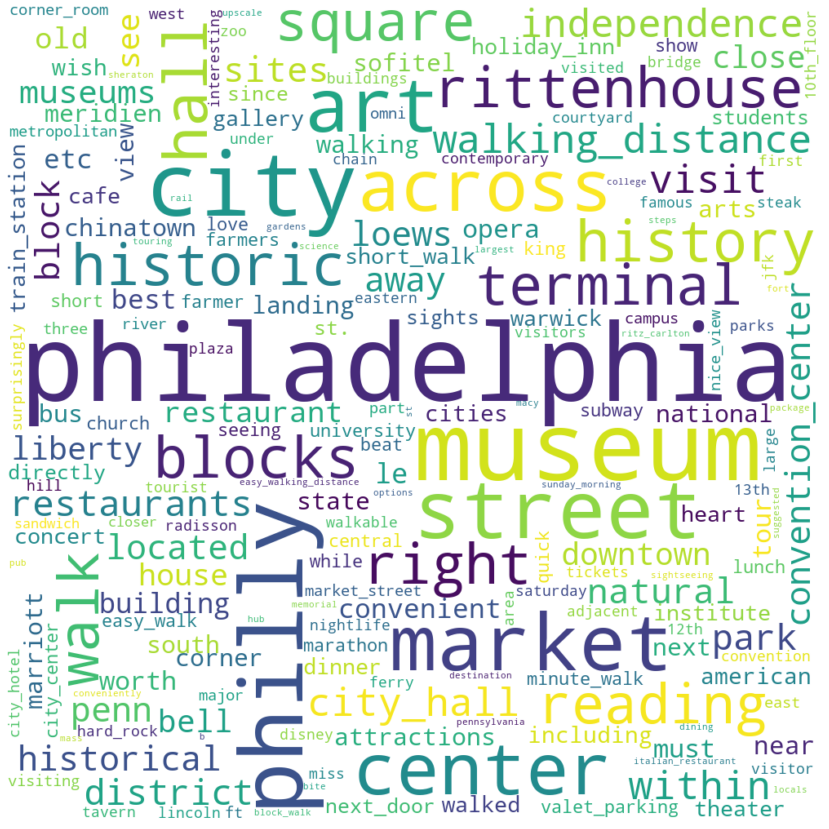

<Figure size 432x288 with 0 Axes>

In [31]:
plt.figure(figsize=(15,15))
freqs = dict(mdl.get_topic_words(72, 200))
wc = WordCloud(width=1000,height=1000,background_color='white').generate_from_frequencies(freqs)
plt.axis('off')
plt.imshow(wc, interpolation='bilinear')
plt.show()
plt.savefig("wordcloud.png")

### Save the final, best model

In [32]:
mdl.save('hotel-topics.bin')